<a href="https://colab.research.google.com/github/HRishabh95/OHE_OCR/blob/Updated/NICE_extract_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import re
import torch

from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
from torch import cuda, tensor

device = 'cuda' if cuda.is_available() else 'cpu'
model = model.to(device)


In [ ]:

url='https://www.nice.org.uk/guidance/published?ndt=Guidance&ngt=Technology%20appraisal%20guidance&ps=9999'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'DNT': '1',  # Do Not Track Request Header
    'Connection': 'keep-alive'
}

# Make the GET request with the specified headers
response = requests.get(url, headers=headers)
html_content = response.text

soup = BeautifulSoup(html_content, 'html.parser')

rows = soup.find_all('tr')

with open('evidence_NICE_lists.csv', 'w', newline='', encoding='utf-8') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Write the CSV header
    csvwriter.writerow(['Title', 'Link', 'TA Number', 'Publication Date', 'Last Reviewed'])

    # Iterate over each row in the table
    for row in rows:
        # Extract data from columns
        cols = row.find_all('td')
        if cols:
            a_tag = cols[0].find('a')
            title = a_tag.text.strip() if a_tag else ''
            link = a_tag['href'] if a_tag else ''
            ta_number = cols[1].text.strip()
            publication_date = cols[2].text.strip()
            last_reviewed = cols[3].text.strip()

            # Write the row data to the CSV file
            csvwriter.writerow([title, link, ta_number, publication_date, last_reviewed])

print("CSV file with links has been created successfully.")


CSV file with links has been created successfully.


In [ ]:

def get_url_data(extension):
    url = f'''https://www.nice.org.uk{extension}'''

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'DNT': '1',  # Do Not Track Request Header
        'Connection': 'keep-alive'
    }


    # Make the GET request with the specified headers
    response = requests.get(url, headers=headers)
    if response.status_code==200:

        html_content = response.text
        return html_content
    else:
        return None
def get_guidance_menu_links(soup):
    guidance_menu = soup.find('nav', class_='stacked-nav')
    final_links=[]
    if guidance_menu:
        links = guidance_menu.find_all('a')
        for link in links[1:]:
            final_links.append([link.get_text(strip=True),link.get('href')])
        return final_links
    else:
        return []

def classify_nice_guidance(text):
    # Categories based on key phrases
    if 'cancer drugs fund' in text.lower():
        CDF = True
    else:
        CDF = False
    if "is not recommended" in text:
        return "Not Recommended", CDF
    # elif "recommended as an option for treating" in text and "Cancer Drugs Fund" in text:
    #     return "Recommended-CDF"
    elif "recommended as an option for" in text and "only if" in text:
        return "Optimised",CDF
    # elif "recommended for use" and "Cancer Drugs Fund" in text:
    #     return "Optimised-CDF"
    elif "recommended, within its marketing authorisation" in text or "recommended" in text:
        return "Recommended",CDF
    else:
        return "Uncategorized",CDF

def get_llm_output(prompt):
    tur_inputs = tokenizer.encode(prompt, return_tensors="pt")
    tur_inputs = tur_inputs.to(device)
    tur_outputs = model.generate(tur_inputs, max_new_tokens=128)
    return tokenizer.decode(tur_outputs[0],skip_special_tokens = True)

def LLM_questions(question_type,MEDICAL_DOCUMENT):
    if question_type=='outcome_tech':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: Which treatment? answer: "
      gen_output=get_llm_output(prompt)

    elif question_type=='outcome_dis':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: For treating which condition? answer: "
      gen_output=get_llm_output(prompt)

    elif question_type=='outcome_text':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: What are the constraints? answer:  "
      gen_output=get_llm_output(prompt)

    elif question_type=='reason_text':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: what are the reasons? answer: "
      gen_output=get_llm_output(prompt)
    elif question_type=='initial_auth':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: For which condition it was initial authorized? answer: "
      gen_output=get_llm_output(prompt)
    elif question_type=='initial_condition':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: Under what conditions is the treatment initially authorized? answer: "
      gen_output=get_llm_output(prompt)
    elif question_type=='price_text':
      prompt=f"Context:{MEDICAL_DOCUMENT} \n Question: what is the price for treatment? answer: "
      gen_output=get_llm_output(prompt)
    return gen_output


def get_recommendation_reason(div_soup):
    reason_text=''
    recommendation_text = ''
    recommendation_cat=''
    CDF=False
    treatment,condition,constraints,reasons_llm='','','',''
    if div_soup.find('div'):
        recommendation_text=div_soup.find('div').get_text(strip=True)
        treatment=LLM_questions('outcome_tech',recommendation_text)
        condition=LLM_questions('outcome_dis',recommendation_text)
        constraints=LLM_questions('outcome_text',recommendation_text)
        recommendation_cat,CDF=classify_nice_guidance(recommendation_text)
        strong_tag = div_soup.find('strong', string="Why the committee made these recommendations")
        if strong_tag:
            for next_p in strong_tag.find_all_next('p'):
                reason_text += next_p.get_text(strip=True) + " "

        if len(reason_text)>1:
          reasons_llm=LLM_questions('reason_text',reason_text)
        return recommendation_text,recommendation_cat,CDF,reason_text,treatment,condition,constraints,reasons_llm
    else:
        return recommendation_text,recommendation_cat,CDF,reason_text,treatment,condition,constraints,reasons_llm


def extract_size(size_str):
    # Extract the numerical value from the size string
    match = re.search(r'(\d+(\.\d+)?)\s*(MB|KB)', size_str, re.I)
    if match:
        size = float(match.group(1))
        unit = match.group(3).upper()
        if unit == 'KB':
            size = size / 1024  # Convert KB to MB
        return size
    return 0


def get_eol_sm(url):
    response = requests.get(url)
    end_of_life = False
    severity = False
    if response.status_code == 200:
        soup = BeautifulSoup(response.text,'html.parser')
        soup_text= soup.get_text()
        if 'end of life' in soup_text.lower():
            end_of_life=True
        if 'severity' in soup_text.lower():
            severity=True
    return end_of_life,severity

def get_information_medicine(div_soup):
    authorisation=''
    auth_condition=''
    auth_treatment=''
    price_value=''
    dosage=''
    price=''
    if div_soup.find('div',title='Marketing authorisation indication'):
        authorisation=div_soup.find('div',title='Marketing authorisation indication').find('p').get_text(strip=True)
        auth_treatment=LLM_questions('initial_auth',authorisation)
        auth_condition=LLM_questions('initial_condition',authorisation)
    if div_soup.find('div',title='Dosage in the marketing authorisation'):
        dosage=div_soup.find('div',title='Dosage in the marketing authorisation').find('p').get_text(strip=True)
    if div_soup.find('div',title='Price'):
        price=div_soup.find('div',title='Price').find('p').get_text(strip=True)
        price_value=LLM_questions('price_text',price)
    return authorisation,dosage,price,auth_condition,auth_treatment,price_value


def extract_nav(soup):
    # Find the nav element with class
    nav = soup.find('nav', attrs={'aria-label': 'Breadcrumbs', 'role': 'navigation'})

    # Extract the last two li elements
    last_two_li = nav.find_all('li')[-2:]
    return last_two_li[0].text.strip(),last_two_li[1].text.strip()

In [ ]:

TAR=pd.read_csv('evidence_NICE_lists.csv',sep=',')

TAR['Publication Date'] = pd.to_datetime(TAR['Publication Date'])

TAR = TAR[TAR['Publication Date'] >= '2013-01-01']



In [ ]:
TAR.head(5)

,Title,Link,TA Number,Publication Date,Last Reviewed
0,Cabozantinib with nivolumab for untreated adva...,https://www.nice.org.uk/guidance/ta964,TA964,2024-04-10,10 April 2024
1,Dostarlimab with platinum-based chemotherapy f...,https://www.nice.org.uk/guidance/ta963,TA963,2024-04-03,3 April 2024
2,Sebelipase alfa for treating lysosomal acid li...,https://www.nice.org.uk/guidance/ta961,TA961,2024-03-28,28 March 2024
3,Olaparib for maintenance treatment of BRCA mut...,https://www.nice.org.uk/guidance/ta962,TA962,2024-03-28,28 March 2024
4,Human alpha1-proteinase inhibitor for treating...,https://www.nice.org.uk/guidance/ta965,TA965,2024-03-28,28 March 2024


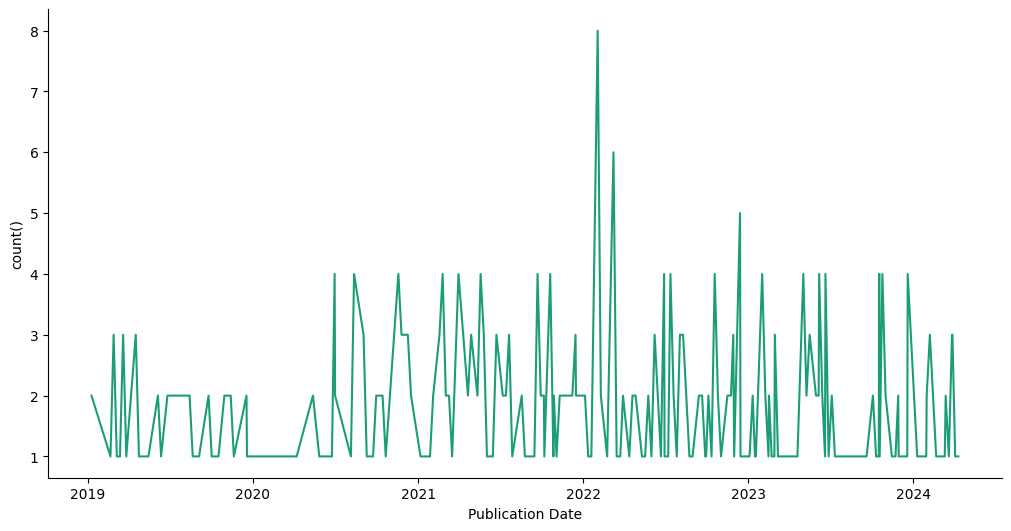

In [ ]:
# @title Publication Date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Publication Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Publication Date'}, axis=1)
              .sort_values('Publication Date', ascending=True))
  xs = counted['Publication Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = TAR.sort_values('Publication Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Publication Date')
_ = plt.ylabel('count()')

In [ ]:

final_csv=[]

for row in TAR.iterrows():
    title=row[1]['Title']
    TAnumber=row[1]['TA Number']
    print(TAnumber)
    extension=f'''/{"/".join(row[1]['Link'].split("/")[-2:])}'''
    recommendation, reason = 'Not Recommended',''
    authorization, dosage, price= '','',''
    html_content=get_url_data(extension)
    recommendation_cat= 'Not Recommended'
    CDF=False
    end_of_life = False
    severity_modifiers = False
    Technology,condition,constraints,reasons_llm='','','',''
    auth_condition,auth_treatment,price_value='','',''

    # Parse the HTML content
    if html_content:
      soup = BeautifulSoup(html_content, 'html.parser')
      guidance_menus=get_guidance_menu_links(soup)

      conditions,subcondition=extract_nav(soup)
      url=f'''{row[1]['Link']}/chapter/3-Committee-discussion'''
      end_of_life,severity_modifiers=get_eol_sm(url)

      for guidance_menu_lists in guidance_menus[:2]:
          guidance_menu_list=guidance_menu_lists[1]
          make_id=f'''{guidance_menu_list.split("/")[2]}-{guidance_menu_list.split("/")[4].lower()}'''
          soup = BeautifulSoup(get_url_data(guidance_menu_list),'html.parser')
          if soup.find('div',id=make_id):
              div_soup = soup.find('div', id=make_id)
          else:
              div_soup = soup.find('div', title=guidance_menu_lists[0])
          # Find the recommendation and reason sections
          if "recommendation" in make_id:
              recommendation,recommendation_cat,CDF,reason,Technology,condition,constraints,reasons_llm=get_recommendation_reason(div_soup)
          if 'information-about' in make_id:
              authorization,dosage,price,auth_condition,auth_treatment,price_value=get_information_medicine(div_soup)

      final_csv.append([TAnumber,conditions,subcondition,title,recommendation,Technology,condition,constraints,recommendation_cat,CDF,reason,reasons_llm,authorization,auth_condition,
                        auth_treatment,dosage,price,price_value,
                        end_of_life,severity_modifiers])


TA964


Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


TA963
TA961
TA962
TA965
TA958
TA959
TA960
TA957
TA953
TA955
TA878
TA956
TA954
TA952
TA949
TA950
TA951
TA947
TA948
TA945
TA946
TA944
TA937
TA940
TA941
TA942
TA943
TA755
TA939
TA938
TA935
TA936
TA933
TA934
TA932
TA931
TA930
TA929
TA928
TA917
TA924
TA925
TA926
TA923
TA919
TA920
TA921
TA922
TA927
TA918
TA915
TA916
TA914
TA913
TA875
TA912
TA911
TA910
TA909
TA906
TA908
TA907
TA902
TA903
TA904
TA905
TA901
TA898
TA900
TA894
TA895
TA896
TA893
TA897
TA899
TA891
TA892
TA888
TA889
TA890
TA886
TA887
TA881
TA882
TA883
TA884
TA880
TA879
TA877
TA876
TA871
TA873
TA874
TA872
TA870
TA867
TA869
TA868
TA865
TA866
TA861
TA862
TA863
TA864
TA860
TA859
TA857
TA858
TA856
TA853
TA849
TA850
TA851
TA852
TA854
TA848
TA845
TA846
TA847
TA844
TA843
TA841
TA842
TA839
TA840
TA838
TA837
TA836
TA830
TA832
TA833
TA835
TA834
TA827
TA828
TA829
TA823
TA825
TA826
TA822
TA824
TA820
TA821
TA819
TA818
TA815
TA816
TA817
TA812
TA813
TA814
TA811
TA809
TA810
TA803
TA805
TA806
TA807
TA808
TA804
TA799
TA800
TA801
TA802
TA798
TA796
TA79

In [ ]:
dd=pd.DataFrame(final_csv)
dd.columns=['TA_Number','Disease','SubDisease','Indication','Outcome','Treatment','Condition','Constraints','Category','CDF','Reasons','Reason_LLM','Initial Authorization'
                                                       ,'Authorization_Condition','Authorization_Treatment','Dosage','Price','Price_Value','EoL','Severity Modifiers']


dd.to_csv('Recommendations_NICE_papers.tsv',sep=';',index=False)

In [ ]:
dd

,TA_Number,Disease,SubDisease,Indication,Outcome,Treatment,Condition,Constraints,Category,CDF,Reasons,Reason_LLM,Initial Authorization,Authorization_Condition,Authorization_Treatment,Dosage,Price,Price_Value,EoL,Severity Modifiers
0,TA964,Cancer,Renal cancer,Cabozantinib with nivolumab for untreated adva...,Cabozantinib with nivolumab is recommended as ...,cabozantinib with nivolumab,untreated advanced renal cell carcinoma,their disease is intermediate or poor risk as ...,Optimised,False,Untreated advanced renal cell carcinoma is tre...,Clinical trial evidence suggests that people h...,"Cabozantinib (Cabometyx, Ipsen) with nivolumab...",advanced renal cell carcinoma,advanced renal cell carcinoma,The dosage schedule is available in thesummary...,"The list price of cabozantinib is £5,143.00 pe...",yes,False,True
1,TA963,Cancer,Endometrial cancers,Dostarlimab with platinum-based chemotherapy f...,Dostarlimab with platinum-based chemotherapy i...,Dostarlimab with platinum-based chemotherapy,endometrial cancer,conditions in themanaged access agreementfor d...,Recommended,False,Usual treatment for primary advanced or recurr...,Because of the uncertainty in the clinical eff...,"Dostarlimab (Jemperli, GSK) is indicated 'in c...",mismatch repair deficient (dMMR)/ microsatelli...,mismatch repair deficient,The dosage schedule is available in thesummary...,"The list price for dostarlimab is £5,887.33 pe...",yes,False,False
2,TA961,Cardiovascular conditions,Lipid disorders,Sebelipase alfa for treating lysosomal acid li...,Not Recommended,,,,Not Recommended,False,,,,,,,,,False,False
3,TA962,Cancer,Ovarian cancer,Olaparib for maintenance treatment of BRCA mut...,"Olaparib is recommended, within its marketing ...",platinum-based chemotherapy,"BRCA mutation-positive, advanced (FIGO stages ...",It is only recommended if the company provides...,Recommended,False,This evaluation reviews the evidence for olapa...,The new clinical evidence shows that people ha...,"Olaparib (Lynparza, AstraZeneca) is indicated ...",advanced (FIGO stages III and IV) BRCA1/2-muta...,BRCA1/2-mutated (germline and/or somatic) high...,The dosage schedule is available in thesummary...,"The list price for olaparib is £2,317.50 (56 x...","£4,635.00",False,False
4,TA965,Respiratory conditions,Chronic obstructive pulmonary disease,Human alpha1-proteinase inhibitor for treating...,Not Recommended,,,,Not Recommended,False,,,,,,,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,TA562,Cancer,Metastases,Encorafenib with binimetinib for unresectable ...,1.1Encorafenib with binimetinib is recommended...,encorafenib with binimetinib,unresectable or metastatic BRAF V600 mutation-...,It is recommended only if the company provides...,Recommended,False,Current treatments for unresectable or metasta...,"Clinical trial evidence shows that, compared w...",,,,"2.2For encorafenib, the recommended dose is 45...",2.3The list price for 42 capsules of encorafen...,The list price for 42 capsules of encorafenib ...,False,False
376,TA563,Cancer,Breast cancer,Abemaciclib with an aromatase inhibitor for pr...,1.1Abemaciclib with an aromatase inhibitor is ...,Abemaciclib with an aromatase inhibitor,"locally advanced or metastatic, hormone recept...",Abemaciclib is recommended only if the company...,Recommended,False,"Palbociclib or ribociclib, taken with an aroma...",Clinical trial evidence shows that abemaciclib...,,,,2.2The recommended dose is 150 mg taken orally...,"2.3£2,950 for 56×150 mg tablets (excluding VAT...","2.3£2,950",False,False
377,TA560,Cancer,Ovarian cancer,"Bevacizumab with carboplatin, gemcitabine and ...",Not Recommended,,,,Not Recommended,False,,,,,,,,,False,False
378,TA555,Cancer,Liver cancers,Regorafenib for previously treated advanced he...,1.1Regorafenib is recommended as an option for...,sorafenib,advanced unresectable hepatocellular carcinoma,Child–Pugh grade A liver impairment and an Eas...,Optimised,False,Advanced unresect

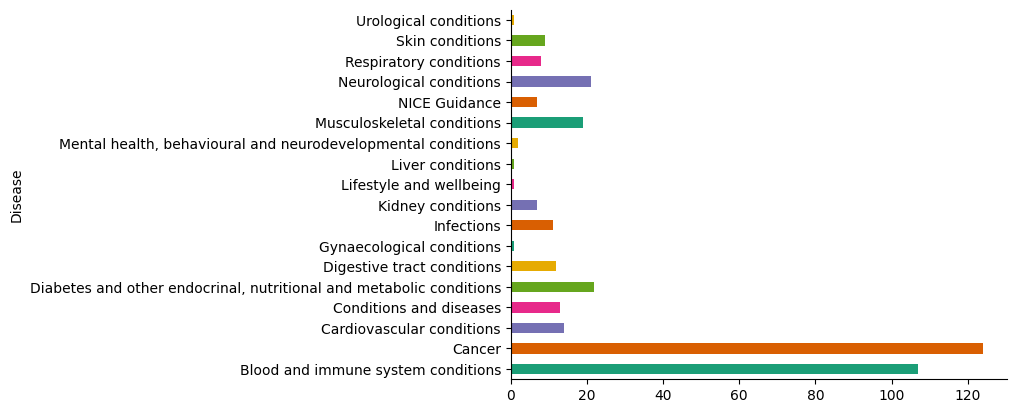

In [ ]:
# @title Category

from matplotlib import pyplot as plt
import seaborn as sns
dd.groupby('Disease').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)